# Assignment 3
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

## Part 3: Implementing your stance classification system
***

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Specify dataset column names
column_names = ['sentiment', 'comments']

# Load dataset
sample_df = pd.read_csv('data/a3_first_sample.tsv', sep='\t', header=None, names=column_names)
training_df = pd.read_csv('data/a3_train_final.tsv', sep='\t', header=None, names=column_names) 
test_df = pd.read_csv('data/a3_test.tsv', sep='\t', header=None, names=column_names)

# Display first 10 rows of the datasets
training_df.head(10)

,sentiment,comments
0,1/1,I'll only consume if I know what's inside it....
1,0/-1,It is easier to fool a million people than it...
2,0/0,NATURAL IMMUNITY protected us since evolutio...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...
4,0/0,"Proud to have resisted. Proud of my husband, ..."
5,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...
6,1/-1,Unvaccinated people are more likely to become...
7,1/1,Vaccine takes more than a year to develop. T...
8,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
9,0/0,"covid vaccines are safe , Goes to show , if ..."


In [2]:
# Information about the dataset
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  975 non-null    int64 
 1   comments   975 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


In [3]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50068 entries, 0 to 50067
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50068 non-null  object
 1   comments   50068 non-null  object
dtypes: object(2)
memory usage: 782.4+ KB


In [4]:
# Determine the amount of missing values in the datasets
sample_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [5]:
training_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [6]:
# Count the frequency of each unique sentiment combination
sentiment_counts = training_df['sentiment'].value_counts()

# Calculate the consensus metrics
total_rows = len(training_df)
full_consensus_count = sentiment_counts[sentiment_counts.index.map(lambda x: len(set(x.split('/'))) == 1)].sum()
partial_consensus_count = total_rows - full_consensus_count

# Calculate the percentages
full_consensus_percentage = (full_consensus_count / total_rows) * 100
partial_consensus_percentage = (partial_consensus_count / total_rows) * 100

# Print the consensus analysis
print(f"Total number of rows: {total_rows}")
print(f"Rows with full consensus: {full_consensus_count} ({full_consensus_percentage:.2f}%)")
print(f"Rows with partial or no consensus: {partial_consensus_count} ({partial_consensus_percentage:.2f}%)")

# Display the frequency of each unique sentiment combination
print("\nFrequency of each unique sentiment combination:")
print(sentiment_counts)

Total number of rows: 50068
Rows with full consensus: 42247 (84.38%)
Rows with partial or no consensus: 7821 (15.62%)

Frequency of each unique sentiment combination:
1/1                            19248
0/0                            18221
0/-1                            2434
1/-1                            2082
1/0                             1467
                               ...  
0/1/0/0/0                          1
0/0/1/-1                           1
1/1/1/1/1/1/1/1/1/0/1/1/1/1        1
0/1/0/1/1/0/0/1                    1
1/0/-1/-1                          1
Name: sentiment, Length: 190, dtype: int64


Sentiment Combination Approach

In [7]:
def extract_majority_label(labels):
    """
    Extracts the majority label from a string of annotations separated by '/'.
    Returns None if there's no clear majority.
    """
    label_counts = Counter(labels.split('/'))
    most_common = label_counts.most_common()

    # Check if there's a clear majority or if it's a tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None  # It's a tie or no clear majority
    return most_common[0][0]  # Return the label with the majority

In [8]:
# Apply the function to extract the majority label or filter out non-consensus comments
training_df['major_sentiment'] = training_df['sentiment'].apply(extract_majority_label)

# Filter out rows where MajorityLabel is no consensus
consensus_data = training_df.dropna(subset=['major_sentiment'])
consensus_data = consensus_data.drop(columns=['sentiment']).rename(columns={'major_sentiment': 'sentiment'})

# Display the first few rows of the consensus dataframe and the size of the filtered data
print(consensus_data)
print(f"\nSize of the filtered data: {consensus_data.shape}")

                                                comments sentiment
0       I'll only consume if I know what's inside it....         1
2       NATURAL IMMUNITY  protected us since evolutio...         0
4       Proud to have resisted. Proud of my husband, ...         0
5       The bigest sideffect of vaccines is fewer dea...         1
7       Vaccine takes more than a year to develop.  T...         1
...                                                  ...       ...
50063  🤣 keep your 💩 I already know 3 people who have...         0
50064  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...         0
50065  🤣🤣🤣 I took the Vaccine because of work. If I d...         0
50066  🤨there's people already having severe side eff...         0
50067  🥦I ❤my covid vaccines and I'm so excited for m...         1

[42840 rows x 2 columns]

Size of the filtered data: (42840, 2)


Text Preprocessing

In [9]:
def simple_preprocess(sentence):
    """Perform simple preprocessing of text without removing special characters that might affect sentiment."""
    sentence = str(sentence)
    sentence = re.sub(r'http\S+', '', sentence)  # Remove URLs
    sentence = re.sub(r'www\S+', '', sentence)   # Remove URLs
    sentence = re.sub(r'\n', ' ', sentence)      # Replace newline characters with space
    sentence = re.sub(r'\s\s+', ' ', sentence)   # Replace multiple spaces with a single space
    return sentence.strip()

In [10]:
def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value."""
    score = TextBlob(sentence).sentiment.polarity
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text."""
    return TextBlob(sentence).sentiment.subjectivity

In [11]:
def further_preprocess(sentence):
    """Apply further cleaning and normalization suitable after sentiment analysis."""
    sentence = sentence.lower()
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
    sentence = re.sub(r'[0-9]+', '', sentence)
    sentence = re.sub(r'\s\s+', ' ', sentence)
    return sentence.strip()

Sentiment Analysis

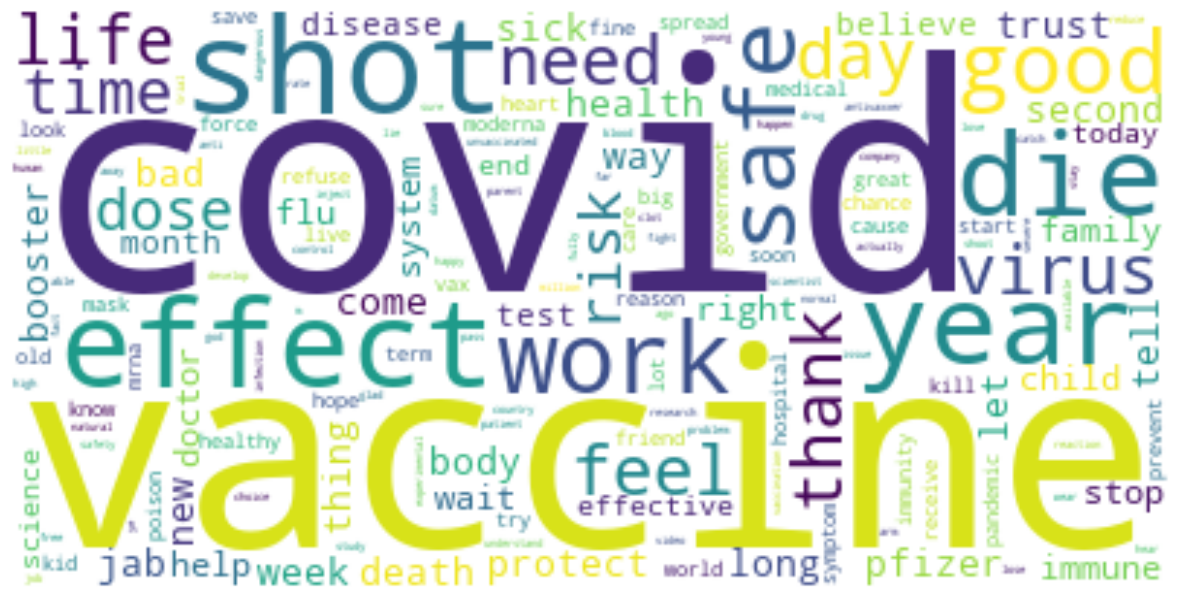

In [14]:
# Now, create a combined set of stop words for use in the WordCloud
stop_words = set(nlp.Defaults.stop_words)

# Concatenate all the comments into a single string
comments_words = ' '.join(consensus_data['final_text'].astype(str))

# Create and generate a word cloud image using the combined set of stop words
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200, collocations=False).generate(comments_words)

# Display the generated word cloud image
plt.figure(figsize=(15, 10))
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

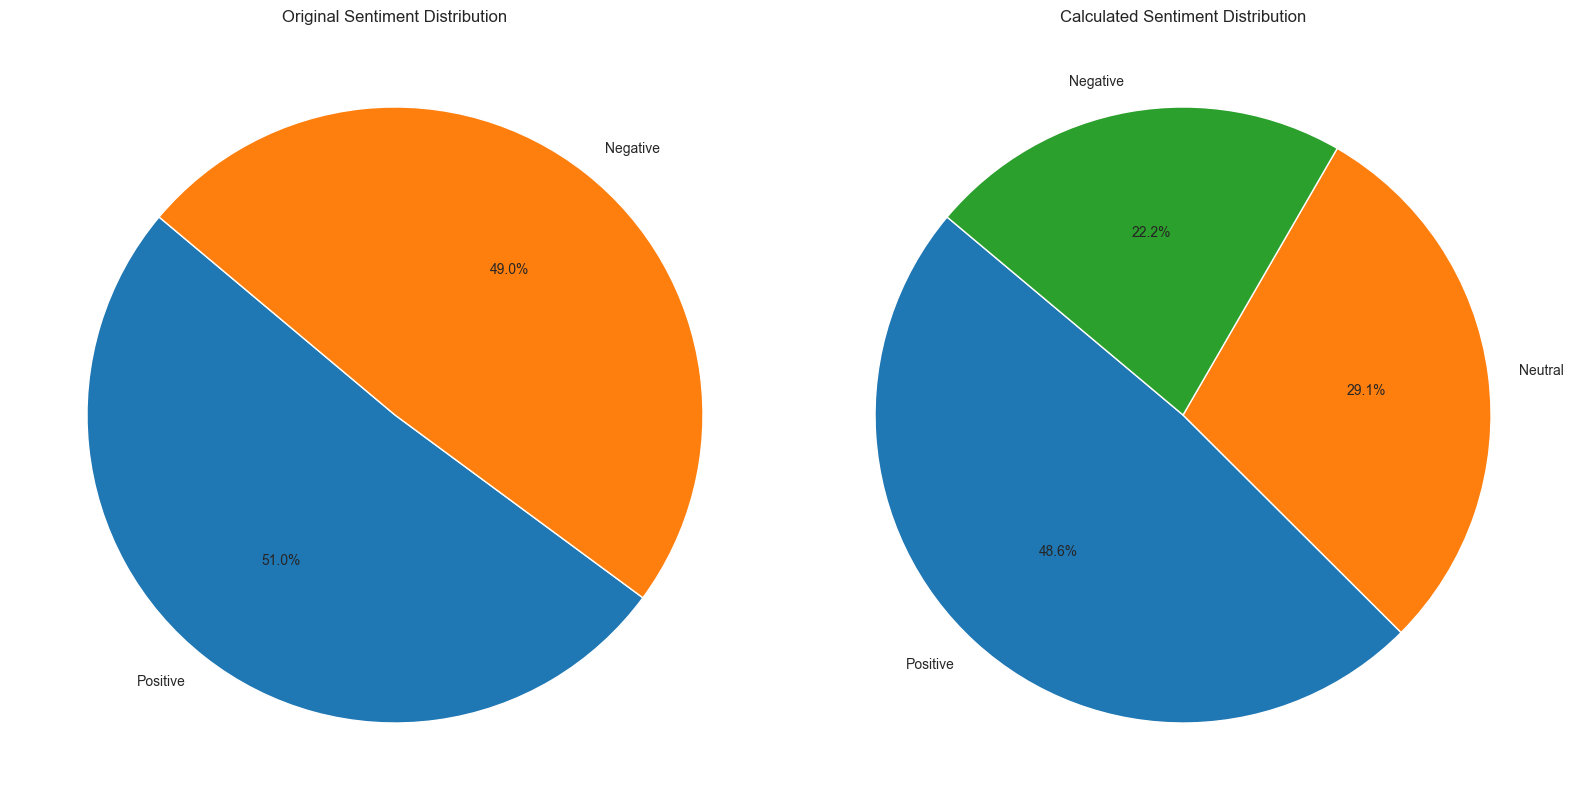

In [15]:
# Map the numerical sentiment values to descriptive categories
sentiment_mapping = {'1': 'Positive', '0': 'Negative'}
consensus_data['sentiment_label'] = consensus_data['sentiment'].map(sentiment_mapping)

# Create pie charts for both original and calculated sentiment distributions
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Original Sentiment Distribution
original_sentiment_counts = consensus_data['sentiment_label'].value_counts(normalize=True)
original_labels = original_sentiment_counts.index

axs[0].pie(original_sentiment_counts, labels=original_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Original Sentiment Distribution')

# Calculated Sentiment Distribution
calculated_sentiment_counts = consensus_data['calculated_sentiment'].value_counts(normalize=True)
calculated_labels = calculated_sentiment_counts.index

axs[1].pie(calculated_sentiment_counts, labels=calculated_labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Calculated Sentiment Distribution')

plt.tight_layout()
plt.show()

In [16]:
def sample_and_compare_sentiment(data, sentiment_type, num_samples=5):
    """
    Samples comments identified with a specific sentiment by TextBlob,
    and compares them with the actual sentiment annotations.
    """
    # Sample instances based on TextBlob identified sentiment
    sampled_comments = data.loc[data['calculated_sentiment'] == sentiment_type, 'comments'].sample(num_samples)

    print(f"Sample comments classified as {sentiment_type} by TextBlob:")
    for i, comment in enumerate(sampled_comments, start=1):
        print(f"{i}. {comment}")

    # Find indices of the sampled comments
    sample_indices = sampled_comments.index

    # Display actual sentiment for these samples
    print(f"\nActual sentiment for the sampled comments classified as {sentiment_type}:")
    for idx in sample_indices:
        actual_sentiment = data.loc[idx, 'sentiment']
        sentiment_label = "Pro-Vaccine" if actual_sentiment == '1' else "Anti-Vaccine"
        print(f"Comment {idx}: {sentiment_label}")
    print()
        
# Sample and compare comments classified as positive and Negative by TextBlob to the actual annotations
sample_and_compare_sentiment(consensus_data, 'Positive')
sample_and_compare_sentiment(consensus_data, 'Negative')

Sample comments classified as Positive by TextBlob:
1. Thanks for sharing this doc it gives me an idea what vaccine woul i take
2. Good stuff!
3. As a pharmacist soon to give COVID19 vaccines in the community I am grateful for the clarification in terms, language and on this platform that reaches the public. There is so much misinformation or information taken out of context that causes confusion, fear and contributes further to vaccine hesitancy. Grateful for this short!
4. got fully vaccinated. Then after a month i got covid hehe... Still thankful for being vaccinated. I have a lot of medical problems that is respiratory related in my previous years such an bronchitis and pneumonia. If i haven't gotten any vaccine. I may have severe symptoms. Luckily i was just classified as asymptomatic when i got covid.
5. My wife was one of them as a healthcare worker. She said it didn’t hurt at all and she still feels fine.

Actual sentiment for the sampled comments classified as Positive:
Commen

## Subjectivity Analysis

In [30]:
# Describe the subjectivity in the comments
consensus_data['calculated_subjectivity'].describe()

count    42818.000000
mean         0.406248
std          0.298956
min          0.000000
25%          0.100000
50%          0.444610
75%          0.602083
max          1.000000
Name: calculated_subjectivity, dtype: float64

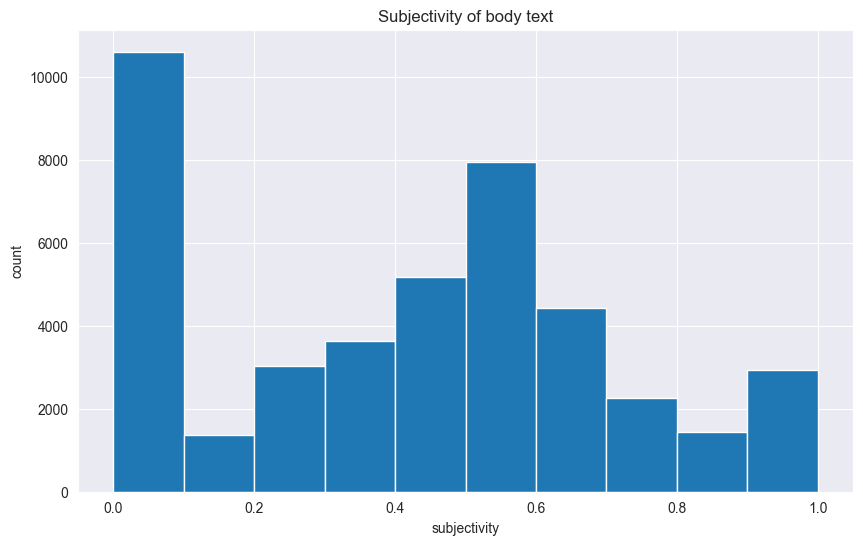

In [31]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(consensus_data['calculated_subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

## Machine Learning Data Preparation

In [17]:
# Split the training and final test data into features and target
X = consensus_data['final_text']
y = consensus_data['sentiment']
X_test_final = test_df['final_text']
y_test_final = test_df['sentiment']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

Baseline Models

In [18]:
# Function to create, fit, and evaluate a model
def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
    print(classification_report(y_val, y_pred, zero_division=0))
    return model

In [19]:
def plot_model_confusion_matrix(model, X_val, y_val):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Logistic Regression Results:
Accuracy: 0.8061653432975245
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6231
           1       0.81      0.82      0.81      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846


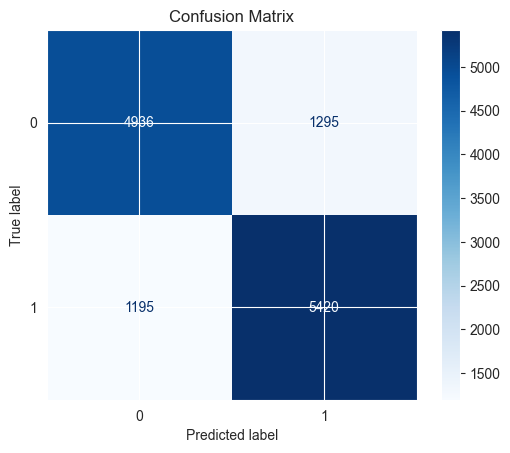


Naive Bayes Results:
Accuracy: 0.8107582126732057
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      6231
           1       0.79      0.86      0.82      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846


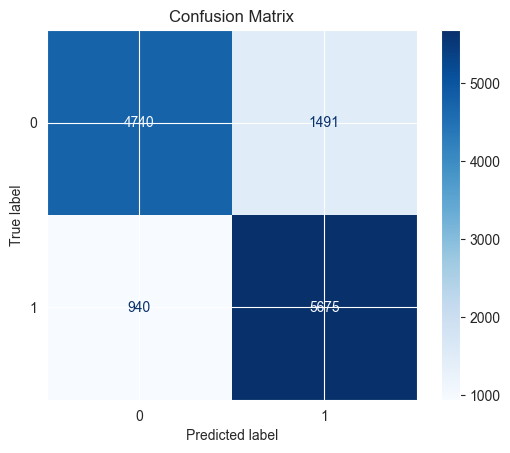


LinearSVC Results:
Accuracy: 0.8153510820488868
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      6231
           1       0.82      0.83      0.82      6615

    accuracy                           0.82     12846
   macro avg       0.82      0.82      0.82     12846
weighted avg       0.82      0.82      0.82     12846


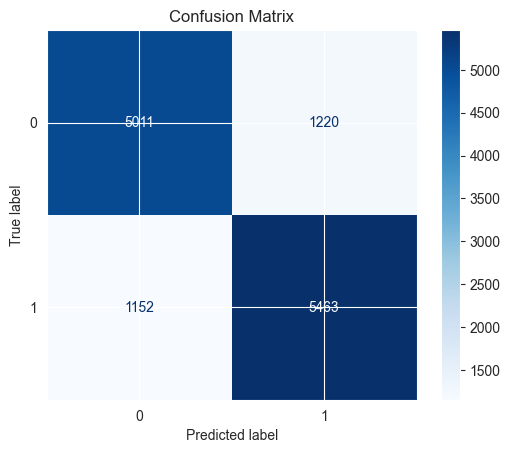


Random Forest Results:
Accuracy: 0.7908298302973689
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6231
           1       0.81      0.77      0.79      6615

    accuracy                           0.79     12846
   macro avg       0.79      0.79      0.79     12846
weighted avg       0.79      0.79      0.79     12846


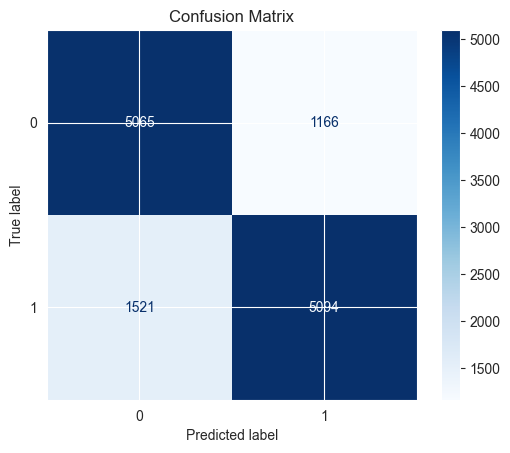

In [20]:
# Logistic Regression Pipeline
print("Logistic Regression Results:")
lr_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression(C=1, random_state=0))
lr_model = evaluate_model(lr_pipeline, X_train, X_val, y_train, y_val)
plot_model_confusion_matrix(lr_model, X_val, y_val)

# Naive Bayes Pipeline
print("\nNaive Bayes Results:")
nb_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())
nb_model = evaluate_model(nb_pipeline, X_train, X_val, y_train, y_val)
plot_model_confusion_matrix(nb_model, X_val, y_val)

# SVC Pipeline
print("\nLinearSVC Results:")
svc_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=0))
svc_model = evaluate_model(svc_pipeline, X_train, X_val, y_train, y_val)
plot_model_confusion_matrix(svc_model, X_val, y_val)

# Random Forest Pipeline
print("\nRandom Forest Results:")
rf_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), RandomForestClassifier(random_state=0))
rf_model = evaluate_model(rf_pipeline, X_train, X_val, y_train, y_val)
plot_model_confusion_matrix(rf_model, X_val, y_val)

Hyperparameter Tuning

In [21]:
# Logistic Regression hyperparameter distribution
lr_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'logisticregression__C': loguniform(1e-4, 1e2),  # Log-uniform distribution
    'logisticregression__penalty': ['l1', 'l2'],  # Regularization penalty
}

# Create a Logistic Regression pipeline
lr_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='saga', random_state=0))

# Set up RandomizedSearchCV for Logistic Regression
lr_random_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
lr_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=0,
                                                                 solver='saga'))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BF7A679060>,
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'tfidfvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BF732739A0>,
                                        'tfidfvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_fr

In [22]:
nb_param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': [0.5, 0.7, 0.9],
    'tfidfvectorizer__min_df': [1, 2, 5],
    'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
}

# Set up RandomizedSearchCV for Multinomial Naive Bayes
nb_random_search = RandomizedSearchCV(
    nb_pipeline,
    param_distributions=nb_param_grid,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
nb_random_search.fit(X_train, y_train)

# Obtain the best Naive Bayes model from the random search
nb_best_model = nb_random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [23]:
# LinearSVC hyperparameter distribution
svc_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'linearsvc__C': uniform(0.1, 10),
}

# Create a LinearSVC pipeline
svc_pipeline = make_pipeline(TfidfVectorizer(), LinearSVC(random_state=0))

# Set up RandomizedSearchCV for LinearSVC
svc_random_search = RandomizedSearchCV(
    svc_pipeline,
    param_distributions=svc_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
svc_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('linearsvc',
                                              LinearSVC(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BF732E59C0>,
                                        'tfidfvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BF70B5DCF0>,
                                        'tfidfvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BF7A679F90>,
                                        'tfidfvectorizer__ngram_range': [(1, 1),
                                                                         (1,
                                                                      

In [24]:
# Random Forest hyperparameter distribution
rf_param_distributions = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest pipeline
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=0))

# Set up RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              None],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                  

In [25]:
# Evaluate the best model from RandomizedSearchCV
def evaluate_best_model(random_search, X_val, y_val):
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_val)
    print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
    print(classification_report(y_val, y_pred, zero_division=0))
    print(f"Best parameters: {random_search.best_params_}")

# Evaluate Logistic Regression best model
print("Best Logistic Regression Model:")
evaluate_best_model(lr_random_search, X_val, y_val)

# Evaluate LinearSVC best model
print("\nBest LinearSVC Model:")
evaluate_best_model(svc_random_search, X_val, y_val)

# Evaluate Random Forest best model
print("\nBest Random Forest Model:")
evaluate_best_model(rf_random_search, X_val, y_val)

# Evaluate Multinomial Naive Bayes model
print("\nBest  Naive Bayes Model:")
evaluate_best_model(nb_random_search, X_val, y_val)

Best Logistic Regression Model:
Test accuracy: 0.6553012610929472
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      6231
           1       0.69      0.61      0.64      6615

    accuracy                           0.66     12846
   macro avg       0.66      0.66      0.66     12846
weighted avg       0.66      0.66      0.65     12846

Best parameters: {'logisticregression__C': 0.13523525694052882, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__max_df': 0.8420801258039972, 'tfidfvectorizer__min_df': 0.019316617166338, 'tfidfvectorizer__ngram_range': (1, 1)}

Best LinearSVC Model:
Test accuracy: 0.7078468005604858
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      6231
           1       0.73      0.69      0.71      6615

    accuracy                           0.71     12846
   macro avg       0.71      0.71      0.71     12846
weighted avg       0.71      0.71      0.71 

Model Evaluation

Classification Report (Cross-Validated):
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     14750
           1       0.79      0.84      0.81     15222

    accuracy                           0.81     29972
   macro avg       0.81      0.81      0.81     29972
weighted avg       0.81      0.81      0.81     29972

Accuracy (Cross-Validated):
0.806519418123582


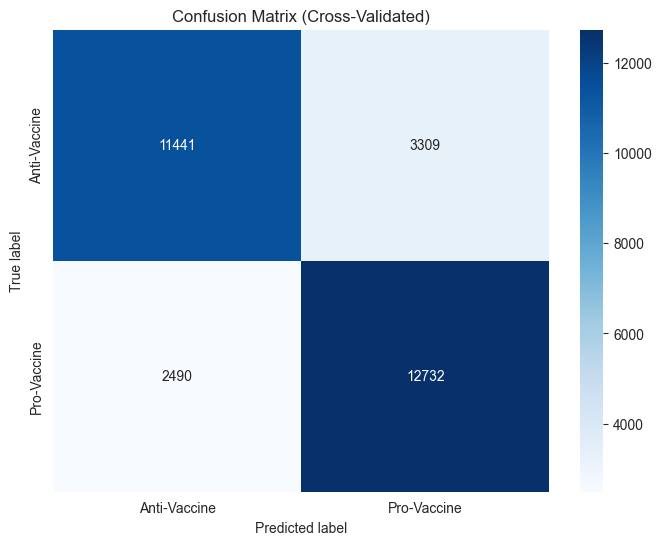

In [26]:
# Function to plot confusion matrix
def plot_confusion_matrix_of_best_model(y_true, y_pred, classes, title='Confusion matrix'):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Generate cross-validated estimates for each input data point
y_pred_cv = cross_val_predict(nb_best_model, X_train, y_train, cv=10)

# Evaluate the predicted target values and accuracy
print("Classification Report (Cross-Validated):")
print(classification_report(y_train, y_pred_cv))
print("Accuracy (Cross-Validated):")
print(accuracy_score(y_train, y_pred_cv))

# Plotting the confusion matrix using the custom function
plot_confusion_matrix_of_best_model(y_train, y_pred_cv, classes=['Anti-Vaccine', 'Pro-Vaccine'], title='Confusion Matrix (Cross-Validated)')

Evaluate on final test set

Classification Report (Separate Test Set):
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1020
           1       0.81      0.86      0.83      1019

    accuracy                           0.83      2039
   macro avg       0.83      0.83      0.83      2039
weighted avg       0.83      0.83      0.83      2039

Accuracy (Separate Test Set):
0.8278567925453654


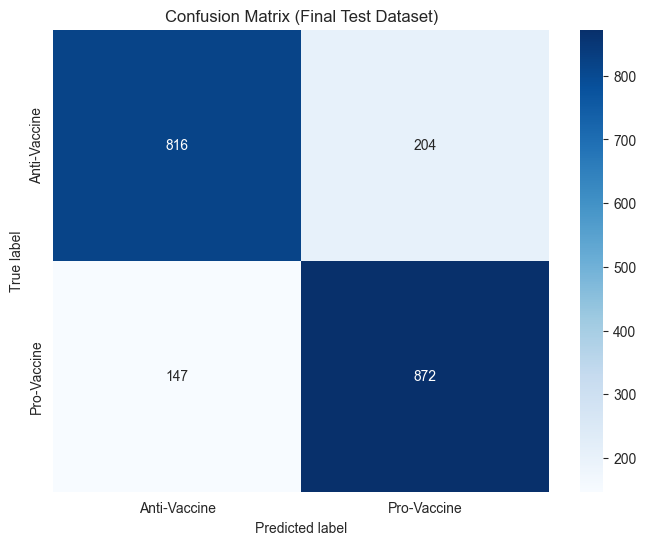

In [27]:
# Evaluating the Naive Bayes model on the separate test dataset
y_pred_test_final = nb_best_model.predict(X_test_final).astype(int)

# Evaluate performance and plot confusion matrix
print("Classification Report (Separate Test Set):")
print(classification_report(y_test_final, y_pred_test_final))
print("Accuracy (Separate Test Set):")
print(accuracy_score(y_test_final, y_pred_test_final))
plot_confusion_matrix_of_best_model(y_test_final, y_pred_test_final, classes=['Anti-Vaccine', 'Pro-Vaccine'], title='Confusion Matrix (Final Test Dataset)')

## Mispredicted Comments

In [28]:
# Retrieve the index of mispredicted comments
incorrect_indices = np.where(y_train != y_pred_cv)[0]

# Sample a few incorrect predictions
sample_incorrect_indices = np.random.choice(incorrect_indices, size=min(5, len(incorrect_indices)), replace=False)

print("Sample Incorrect Predictions:")
for idx in sample_incorrect_indices:
    original_idx = X_train.index[idx]  # Get the original index if X_train has been reset
    print(f"Index: {original_idx}, Predicted: {y_pred_cv[idx]}, Actual: {y_train.iloc[idx]}")
    print(f"Text: {consensus_data.loc[original_idx, 'comments']}\n")

Sample Incorrect Predictions:
Index: 18637, Predicted: 0, Actual: 1
Text: I'm 66 years in USA, I was required by law, as a child to have every vaccination of value for young children. Then I was vaccinated the hell out of when I joined the US Navy in boot camp. I've had tetanus shots, pneumonia shots, shingles, flu shots the last 10 years. I'm as perfectly healthy and more so than others my age or even younger. So,,, F you, you anti-vaccination aholes! Stop being dicks!

Index: 5041, Predicted: 1, Actual: 0
Text: Clever considering they don't even know what they're vaccinating against cause the virus..HAS NEVER BEEN ISOLATED !!!!!

Index: 1175, Predicted: 1, Actual: 0
Text: @HSRetoucher PERHAPS, They REALLY Aren't In Lines For The COVID-19 Vaccine.....PERHAPS They Are In Line For The Bread Lines..... and they make it appear it's for the Vaccine..... ALL I Know, Is With ALL These IDIOTS Globally, I'm Safe Without Having To Take The COVID-19 Vaccine CRAP

Index: 13438, Predicted: 0, Actu

References
